In [1]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, get_linear_schedule_with_warmup, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from torch.optim import AdamW

from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

#### Source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/#31-bert-tokenizer

In [2]:
EPOCHS = 1
MAX_LEN = 128
BATCH_SIZE = 16
SEED_VAL = 42

MODELTYPE = 'bert-base-uncased' #'bert-large-uncased' 

## Test if GPU is available

In [3]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## Data Loading and Tokenization & Input Formatting

In [4]:
# load the dataset
df = pd.read_csv('../datasets/01_preprocessed_datasets/dataset_preprocessed.csv')

# map hate to 1 and non-hate to 0
df['label'] = df['label'].map({'hate': 1, 'not_hate': 0})

sentences = df['text'].values
labels = df['label'].values

In [5]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODELTYPE, do_lower_case=True)

Loading BERT tokenizer...


In [6]:
# example tokenization
print('Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  i hate woman
Tokenized:  ['i', 'hate', 'woman']
Token IDs:  [1045, 5223, 2450]


In [7]:
max_len = 0

for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length:', max_len)

Max sentence length:  443


In [8]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                           # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding = 'max_length',         # padding to max_len
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                        truncation=True                 # truncate the sentence to max_len
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original:', sentences[0])
print('Token IDs:', input_ids[0])

Original:  i hate woman
Token IDs: tensor([ 101, 1045, 5223, 2450,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


## Data Splitting

In [9]:
generator1 = torch.Generator().manual_seed(SEED_VAL)

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.6, 0.2, 0.2], generator=generator1)

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>6,} validation samples'.format(len(val_dataset)))
print('{:>6,} test samples\n'.format(len(test_dataset)))

print('Whole dataset size:', len(train_dataset) + len(val_dataset) + len(test_dataset))
print('Whole dataset size:', len(dataset))

26,924 training samples
 8,974 validation samples
 8,974 test samples

Whole dataset size: 44872
Whole dataset size: 44872


In [10]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

testing_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

## Creating Model

In [11]:
model = BertForSequenceClassification.from_pretrained(
    MODELTYPE,
    num_labels = 2, 
    output_attentions = False,
    output_hidden_states = False,
)

# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [13]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5
                  eps = 1e-8 # default is 1e-8.
                )

In [14]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [15]:
MODELTYPE = MODELTYPE.replace('-', '_')

## Training the Model

In [16]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [18]:
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print(f'======== Epoch {epoch_i + 1} / {EPOCHS} ========')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_accuracy = 0
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 200 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.    Elapsed: {elapsed}.')

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     labels=b_labels).loss
        
        logits = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels).logits

        total_train_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)

        # Perform a backward pass to calculate the gradients.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average accuracy over all of the batches.
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print(f"  Average training accuracy: {avg_train_accuracy:.2f}")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time:}")
        
    # ========================================
    #               Validation
    # ========================================
 
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
   
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            loss = model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask,
                         labels=b_labels).loss
        
            logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels).logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Average Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training_Loss': avg_train_loss,
            'Training_Accuracy': avg_train_accuracy,
            'Validation_Loss': avg_val_loss,
            'Validation_Accuracy': avg_val_accuracy,
            'Training_Time': training_time,
            'Validation_Time': validation_time
        }
    )
    
    df_stats = pd.DataFrame(data=training_stats)
    
    # Create output directory if needed
    if not os.path.exists("../performance_statistics"):
        os.makedirs("../performance_statistics")
    
    df_stats.to_csv(f"../performance_statistics/training_stats_{MODELTYPE}.csv", index=True)
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch   100  of  1,683.    Elapsed: 0:05:36.
  Batch   200  of  1,683.    Elapsed: 0:11:33.
  Batch   300  of  1,683.    Elapsed: 0:17:30.
  Batch   400  of  1,683.    Elapsed: 0:23:29.
  Batch   500  of  1,683.    Elapsed: 0:29:27.
  Batch   600  of  1,683.    Elapsed: 0:35:25.
  Batch   700  of  1,683.    Elapsed: 0:41:25.
  Batch   800  of  1,683.    Elapsed: 0:47:25.
  Batch   900  of  1,683.    Elapsed: 0:53:27.
  Batch 1,000  of  1,683.    Elapsed: 0:59:30.
  Batch 1,100  of  1,683.    Elapsed: 1:05:34.
  Batch 1,200  of  1,683.    Elapsed: 1:11:38.
  Batch 1,300  of  1,683.    Elapsed: 1:17:42.
  Batch 1,400  of  1,683.    Elapsed: 1:23:45.
  Batch 1,500  of  1,683.    Elapsed: 1:29:49.
  Batch 1,600  of  1,683.    Elapsed: 1:35:53.

  Average training loss: 0.50
  Training epoch took: 1:40:56

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.41
  Validation took: 0:02:59

Training complete!
Total training took 1:43:55 (h:m

In [62]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = f'../models/'
filename = f"model_{MODELTYPE}"

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
output_dir = output_dir + filename

print(f"Saving model to {output_dir}")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ../models/model_bert_base_uncased


('../models/model_bert_base_uncased\\tokenizer_config.json',
 '../models/model_bert_base_uncased\\special_tokens_map.json',
 '../models/model_bert_base_uncased\\vocab.txt',
 '../models/model_bert_base_uncased\\added_tokens.json')

## View Training/Validation Results

In [21]:
# Create a DataFrame from our training statistics.
df_stats = pd.read_csv(f"../performance_statistics/training_stats_{MODELTYPE}.csv")
df_stats = df_stats.set_index('Epoch')
df_stats

,Unnamed: 0,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
Epoch,,,,,,
1,0,0.496977,0.407704,0.806659,1:40:56,0:02:59


ValueError: 'locs' must be 1D with shape (N,), but your input has shape (1, 0)

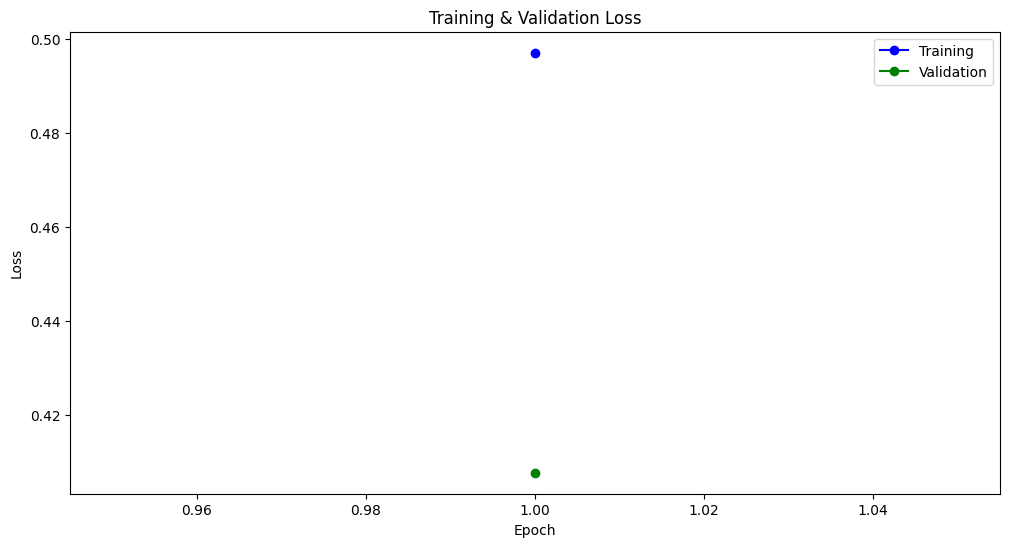

In [23]:
plt.figure(figsize=(12,6))

# Plot the learning curve.
plt.plot(df_stats['Training_Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation_Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([np.arange(1, EPOCHS + 1)])

plt.show()

In [ ]:
plt.figure(figsize=(12,6))

# Plot the learning curve.
plt.plot(df_stats['Training_Accuracy'], 'b-o', label="Training")
plt.plot(df_stats['Validation_Accuracy'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([np.arange(1, EPOCHS + 1)])

plt.show()

In [ ]:
plt.figure(figsize=(12,6))

# Plot the learning curve.
plt.plot(df_stats['Training_Time'], 'b-o', label="Training")
plt.plot(df_stats['Validation_Time'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Time")
plt.xlabel("Epoch")
plt.ylabel("Time")
plt.legend()
plt.xticks([np.arange(1, EPOCHS + 1)])

plt.show()

## Load Model

In [24]:
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Eval on Test Set

In [58]:
# Prediction on test set
print(f'Predicting labels for {len(test_dataset)} test sentences...')

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []
predictions_accuracy, true_labels_accuracy = [], []

# Predict 
for index, batch in enumerate(testing_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
    prediction_list = np.argmax(logits, axis=1).flatten()
    true_labels_list = label_ids.flatten()
    
    for i, prediction in enumerate(prediction_list):
        predictions_accuracy.append(prediction)
        true_labels_accuracy.append(true_labels_list[i])


    if index % 50 == 0:
    
      print(f"Done with {index} out of {len(testing_dataloader)} batches.")
  
print('DONE.')

Predicting labels for 8974 test sentences...
Done with 0 out of 561 batches.
Done with 50 out of 561 batches.
Done with 100 out of 561 batches.
Done with 150 out of 561 batches.
Done with 200 out of 561 batches.
Done with 250 out of 561 batches.
Done with 300 out of 561 batches.
Done with 350 out of 561 batches.
Done with 400 out of 561 batches.
Done with 450 out of 561 batches.
Done with 500 out of 561 batches.
Done with 550 out of 561 batches.
DONE.


In [59]:
report = classification_report(predictions_accuracy, true_labels_accuracy, target_names=['not_hate', 'hate'])

# Save the classification report to a file
with open(f'../performance_statistics/classification_report_{MODELTYPE}.txt', 'w') as file:
    file.write(report)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    not_hate       0.78      0.78      0.78      4091
        hate       0.82      0.82      0.82      4883

    accuracy                           0.80      8974
   macro avg       0.80      0.80      0.80      8974
weighted avg       0.80      0.80      0.80      8974



## Matthews Correlation Coefficient

In [ ]:
print(f'Positive hateful samples: {df.label.sum()} of {len(df.label)} ({df.label.sum() / len(df.label) * 100:.2f}%)')

Positive hateful samples: 24738 of 44872 (55.13%)


In [ ]:
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


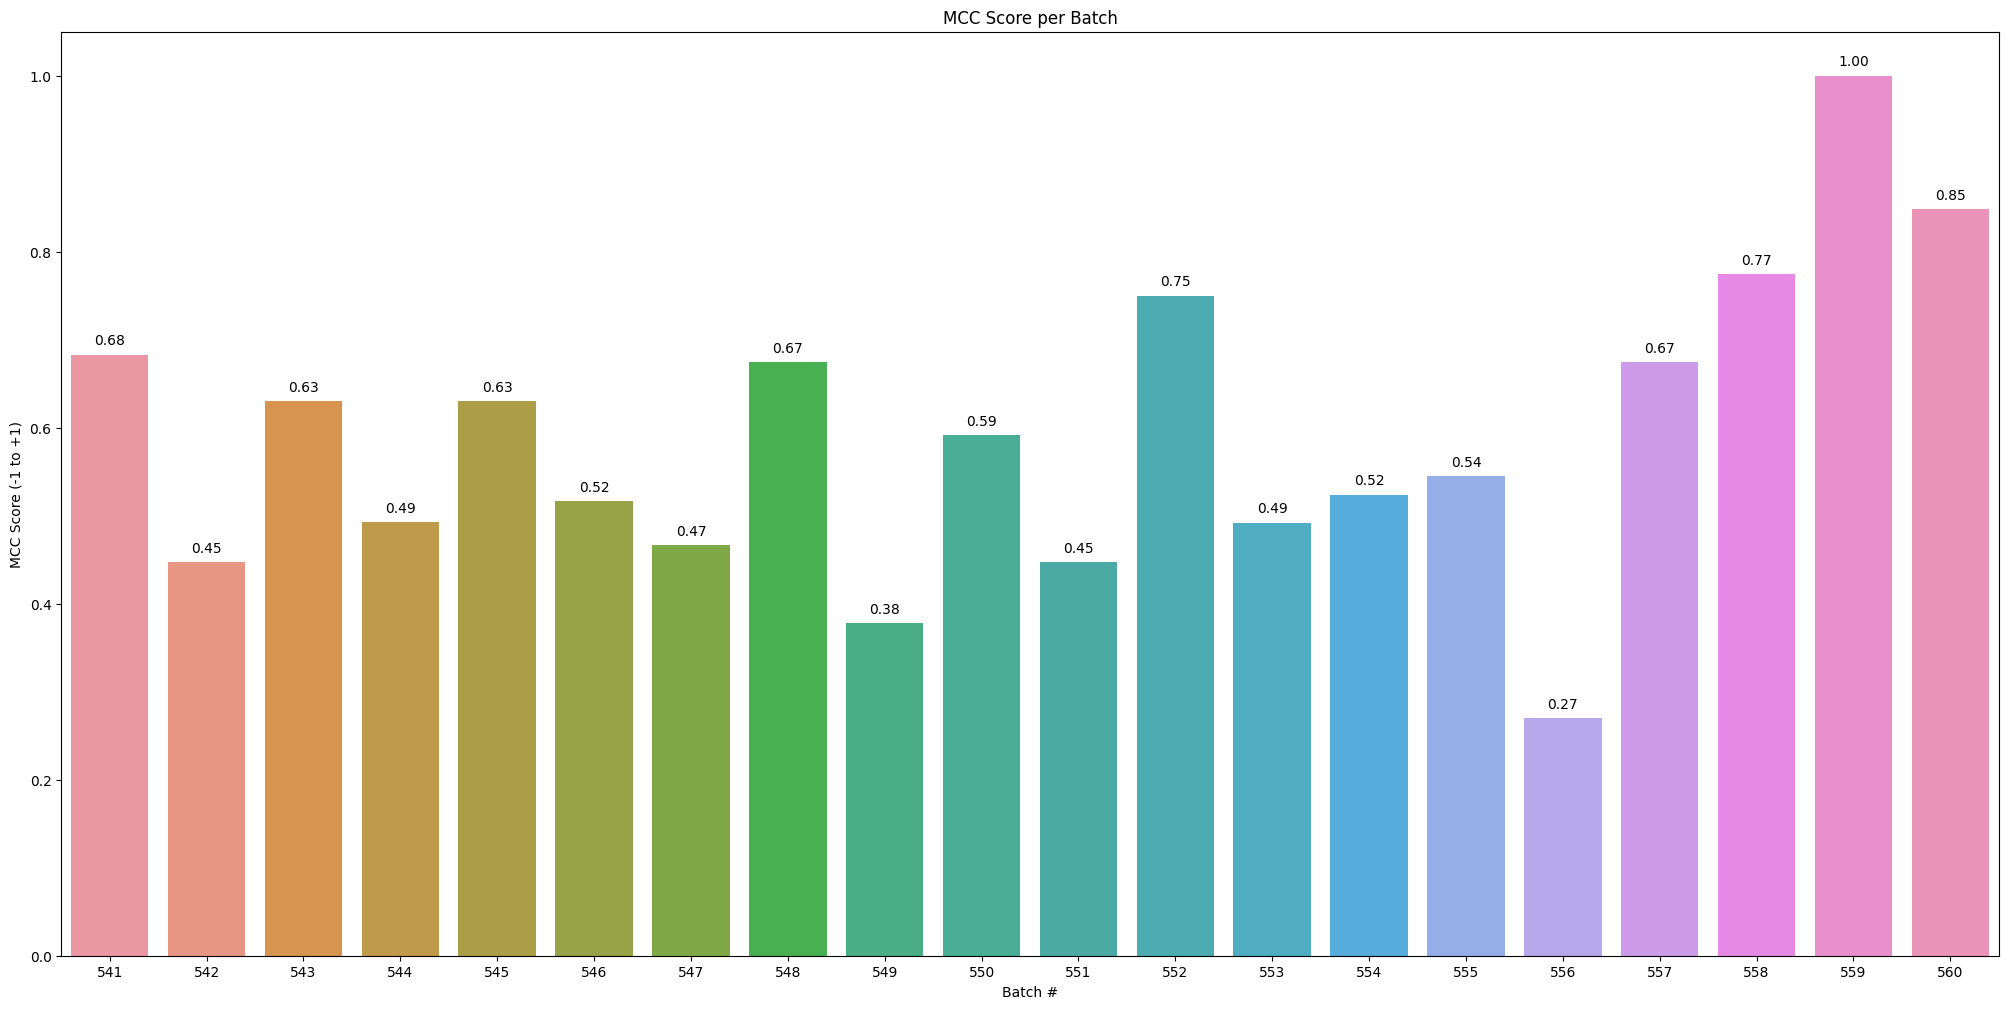

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
plt.figure(figsize=(25, 12))

ax = sns.barplot(x = list(range(len(matthews_set)- 20, len(matthews_set))), y = matthews_set[len(matthews_set) - 20: len(matthews_set)], errorbar=None)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print(f'Total MCC: {mcc:.3f}')

Total MCC: 0.597
